In [2]:
%matplotlib inline
from  pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import matplotlib.patches as patches # For bounding boxes
from PIL import Image
from collections import defaultdict
import json
from tqdm import tqdm_notebook
import os 
import urllib.request
import cv2 as cv
import time

plt.rcParams['figure.figsize'] = (15, 15)

# Define Configurations

In [3]:
# Define paths

dataDir = "COCOdataset2017"
dataValType   = 'val2017'
dataTrainType = 'train2017'
annValFile   ='{}/annotations/instances_{}.json'.format(dataDir,dataValType)
annTrainFile ='{}/annotations/instances_{}.json'.format(dataDir,dataTrainType)

DATA_SOURCE_DIR = "./COCOdataset2017/images"
ANN_DIR   = os.path.join(DATA_SOURCE_DIR, "annotations")
TRAIN_DIR = os.path.join(DATA_SOURCE_DIR, "train")
VAL_DIR   = os.path.join(DATA_SOURCE_DIR, "val")
TEST_DIR  = os.path.join(DATA_SOURCE_DIR, "test")

YOLO_DIR       = "yolo"
YOLO_SETTINGS  = os.path.join(YOLO_DIR, "yolo_settings")
YOLOV3_CFG     = os.path.join(YOLO_SETTINGS, "v3/yolov3.cfg")
YOLOV3_WEIGHTS = os.path.join(YOLO_SETTINGS, "v3/yolov3.weights")

YOLOV4_CFG      = os.path.join(YOLO_SETTINGS, "v4/yolov4.cfg")
YOLOV4_WEIGHTS  = os.path.join(YOLO_SETTINGS, "v4/yolov4.weights")

YOLOV5_NANO_ONNX  = os.path.join(YOLO_SETTINGS, "v5/yolov5n.onnx")
YOLOV5_SIZEX_ONNX = os.path.join(YOLO_SETTINGS, "v5/yolov5x.onnx")

In [4]:
# init COCO api for instance annotations 

cocoTrain = COCO(annTrainFile)
cocoVal   = COCO(annValFile)

loading annotations into memory...


Done (t=10.39s)
creating index...
index created!
loading annotations into memory...
Done (t=1.55s)
creating index...
index created!


In [5]:
def getImages(coco, subCats):

    # Specify classes to download
    catIds      = coco.getCatIds(catNms=subCats)

    # get image ids
    imgIds = coco.getImgIds(catIds=catIds)

    # Load images ids
    images = coco.loadImgs(imgIds)

    return catIds, imgIds, images 

In [6]:
subCats = ['person', 'car', 'bicycle']

catTrainIds, imgTrainIds, trainImages = getImages(cocoTrain, subCats)
catValIds, imgValIds, valImages       = getImages(cocoVal, subCats)

In [7]:
print(f"number of 2017 training   COCO images in {subCats} is {len(trainImages)}")
print(f"number of 2017 validation COCO images in {subCats} is {len(valImages)}")

number of 2017 training   COCO images in ['person', 'car', 'bicycle'] is 1101
number of 2017 validation COCO images in ['person', 'car', 'bicycle'] is 45


In [8]:
# Load names of classes and get random colors
classes = open(os.path.join(YOLO_SETTINGS, 'coco.names')).read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

In [9]:
cat_index_to_name = dict()
cat_name_to_index = dict()
cats = cocoTrain.loadCats(cocoTrain.getCatIds())

for cat in cats:
    cat_index_to_name[cat['id']]   = cat['name']
    cat_name_to_index[cat['name']] = cat['id']

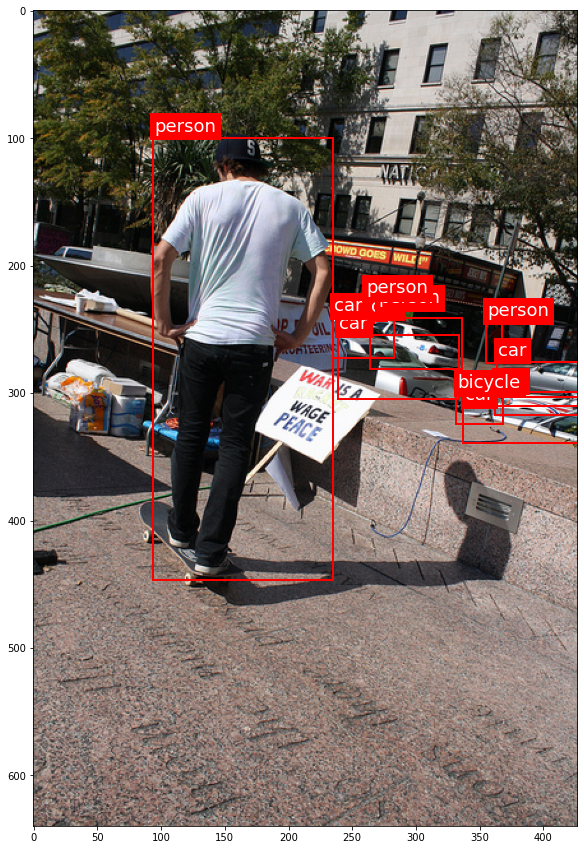

In [10]:
img_json = trainImages[np.random.randint(0, len(trainImages))]
img = cv.imread(os.path.join(TRAIN_DIR, img_json['file_name']))

ground_truths = []

annIds = cocoTrain.getAnnIds(img_json['id'], catIds=catTrainIds, iscrowd=None)
anns   = cocoTrain.loadAnns(annIds)

fig, ax = plt.subplots()

# visualize an image
img = Image.open(os.path.join(TRAIN_DIR, img_json['file_name']))

# visualize bbox im image
for ann in anns:
    ground_truth = {}

    bbox = ann['bbox']
    name_cat = cat_index_to_name[ann['category_id']]

    # extract bbox coordinates
    x = float(bbox[0])
    y = float(bbox[1])
    w = float(bbox[2])
    h = float(bbox[3])

    ground_truth["bbox"] = [x, y, w, h]
    ground_truth["label_name"] = name_cat
    ground_truths.append(ground_truth)

    # add text and bbox
    plt.text(x+1, y-5, name_cat,fontdict={'fontsize':18.0, 'fontweight':'medium','color': 'white', 'backgroundcolor':'red'})
    bb = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(bb)

ax.imshow(img)


# Detect

In [11]:
a = np.array([1, 2])
a[-2]

1

In [29]:
 
# Text parameters.
FONT_FACE = cv.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1
 
# Colors.
BLACK  = (0,0,0)
BLUE   = (255,178,50)
YELLOW = (0,255,255)


class YoloConfig:
    def __init__(self, yolo_cfg, yolo_weight, subClass=[], onnx_path = "", conf_threshold=0.5, nms_threshold=0.4,
                 scaleFactor=float(1/255), inputImageSize=(640, 640), meanValToSubtract=[0, 0, 0],
                 active_gpu=False):
        # yolo conf
        self.yolo_cfg       = yolo_cfg
        self.yolo_weight    = yolo_weight

        # params of input blob
        self.subClass       = subClass
        self.scaleFactor    = scaleFactor
        self.inputImageSize = inputImageSize
        self.meanValToSubtract = meanValToSubtract

        # params conf of post_processing
        self.conf_threshold = conf_threshold
        self.nms_threshold  = nms_threshold

        # onnx
        self.onnx_path = onnx_path

        # gpu option
        self.active_gpu = active_gpu



class objectDetectorYolo:
    def __init__(self, yolo_config : YoloConfig):
        
        self.yolo_config = yolo_config
        self.preds = []
        self.net   = self.load_models(self.yolo_config.active_gpu)


    def get_ouputs_name(self):
        layer_names = self.net.getLayerNames()
        try:
            ouput_layers = [layer_names[i-1]    for i in self.net.getUnconnectedOutLayers()]
        except:
            ouput_layers = [layer_names[i[0]-1] for i in self.net.getUnconnectedOutLayers()]
        
        return ouput_layers
    
    def get_preds(self):
        return self.preds
    
    def refresh_preds(self):
        self.preds.clear()

    def draw_label(self, im, label, x, y):
        """Draw text onto image at location."""
        # Get text size.
        text_size = cv.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
        dim, baseline = text_size[0], text_size[1]
        # Use text size to create a BLACK rectangle.
        cv.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), (0,0,0), cv.FILLED)
        # Display text inside the rectangle.
        cv.putText(im, label, (x, y + dim[1]), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv.LINE_AA)


        # tree main functions : 
        # - load models : load weights from darknet and onnx
        # - pre_processing  : feedforward net 
        # - post_processing : reduce overlapping bounding boxes 

    def load_models(self, active_gpu=False):

        if (self.yolo_config.onnx_path == ""):
            net = cv.dnn.readNetFromDarknet(str(self.yolo_config.yolo_cfg), 
                                        str(self.yolo_config.yolo_weight))
        else:
            net = cv.dnn.readNetFromONNX(self.yolo_config.onnx_path)
 

        if (self.yolo_config.active_gpu):
            print("set gpu")
            net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
            net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA_FP16)
        else:
            net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)        

        return net


    def pre_processing(self, inputImage):
        # Create a 4D blob from a frame.
        # generate blobs from input image
        inputBlob = cv.dnn.blobFromImage(inputImage,  scalefactor = self.yolo_config.scaleFactor, size = self.yolo_config.inputImageSize, swapRB=True, crop=False)
        self.net.setInput(inputBlob)
        # set blob into 
        #outputs = self.net.forward(self.net.getUnconnectedOutLayersNames())
        outputs = self.net.forward(self.get_ouputs_name())
        return outputs


    def process_outputs(self, outputs):
        return outputs[0][0]


    def post_process(self, input_image, outputs):
        # Lists to hold respective values while unwrapping.
        class_ids   = []
        confidences = []
        boxes       = []
        # Rows.
        if (self.yolo_config.onnx_path != ""):
            outputs = self.process_outputs(outputs=outputs)
        else:
            outputs = np.vstack(outputs)

        rows = outputs.shape[0]
        image_height, image_width = input_image.shape[:2]
        # Resizing factor.
        x_factor = image_width   / self.yolo_config.inputImageSize[0]
        y_factor =  image_height / self.yolo_config.inputImageSize[1]
        # Iterate through detections.
        for r in range(rows):
                row = outputs[r]
                confidence = row[4]
                # Discard bad detections and continue.
                if confidence >= self.yolo_config.conf_threshold:
                    classes_scores = row[5:]
                    # Get the index of max class score.
                    class_id = np.argmax(classes_scores)
                    #  Continue if the class score is above threshold.
                    if (classes_scores[class_id] > self.yolo_config.conf_threshold):
                            cx, cy, w, h = row[0], row[1], row[2], row[3]
                            left   = int((cx - w/2) * x_factor)
                            top    = int((cy - h/2) * y_factor)
                            width  = int(w * x_factor)
                            height = int(h * y_factor)
                            box    = np.array([left, top, width, height])

                            confidences.append(confidence)
                            class_ids.append(class_id)
                            boxes.append(box)

        indices = cv.dnn.NMSBoxes(boxes, confidences, self.yolo_config.conf_threshold, self.yolo_config.nms_threshold)
        user_indices = np.array([i for i in indices if classes[class_ids[i]] in self.yolo_config.subClass])

        for i in user_indices:
            box    = boxes[i]
            left   = box[0]
            top    = box[1]
            width  = box[2]
            height = box[3]

            # Draw bounding box.             
            cv.rectangle(input_image, (left, top), (left + width, top + height), BLUE, 3*THICKNESS)
            # Class label.                      
            label = "{}:{:.2f}".format(classes[class_ids[i]], confidences[i])             
            # Draw label.             
            self.draw_label(input_image, label, left, top)
            
        return input_image


    def post_processing(self, inputImage, img_js, outputs):
        H, W = inputImage.shape[:2]

        boxes       = []
        confidences = []
        classIDs    = []

        # resizing factor
        x_factor = W / self.yolo_config.inputImageSize[0]
        y_factor = H / self.yolo_config.inputImageSize[1]

        for output in outputs:
            scores = output[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > self.yolo_config.conf_threshold:
                x, y, w, h = output[:4] * np.array([x_factor, y_factor, x_factor, y_factor])
                p0 = int(x - w//2), int(y - h//2)
                p1 = int(x + w//2), int(y + h//2)


                boxes.append([*p0, int(w), int(h)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                                    
        indices = cv.dnn.NMSBoxes(boxes, confidences, self.yolo_config.conf_threshold, self.yolo_config.nms_threshold)

        # indicate which boxses should be displayed
        user_indices = np.array([i for i in indices if classes[classIDs[i]] in self.yolo_config.subClass])

        if len(user_indices) > 0:
            for i in user_indices:
                pred = {}

                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                print(x, y, w, h)
    
                color = [int(c) for c in colors[classIDs[i]]]# Load names of classes and get random colors
                cv.rectangle(inputImage, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
                cv.putText(inputImage, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                
                pred["image_id"]    = img_js["id"]
                pred["category_id"] = classIDs[i] 
                pred["bbox"]        = [x, y, w, h]
                pred["score"]       = confidences[i]
                self.preds.append(pred)

    
    def detect_objects(self, img_js, show_detect_image=True):
        
        inputImage = cv.imread(os.path.join(TRAIN_DIR, img_js['file_name']))
        outputs = self.pre_processing(inputImage=inputImage)
        img     = self.post_process(input_image=inputImage.copy(), outputs=outputs)
        
        t, _ = self.net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 /  cv.getTickFrequency())
        cv.putText(img, label, (20, 40), cv.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color=(0, 0, 255))

        if show_detect_image:
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [41]:
yolo_sets              = YoloConfig(YOLOV3_CFG, YOLOV3_WEIGHTS, subClass=['person'])
yolo_sets_with_gpu     = YoloConfig(YOLOV3_CFG, YOLOV3_WEIGHTS, subClass=['person'], active_gpu=True)

yolo_detector          = objectDetectorYolo(yolo_config=yolo_sets)
yolo_detector_with_gpu = objectDetectorYolo(yolo_config=yolo_sets_with_gpu)

set gpu


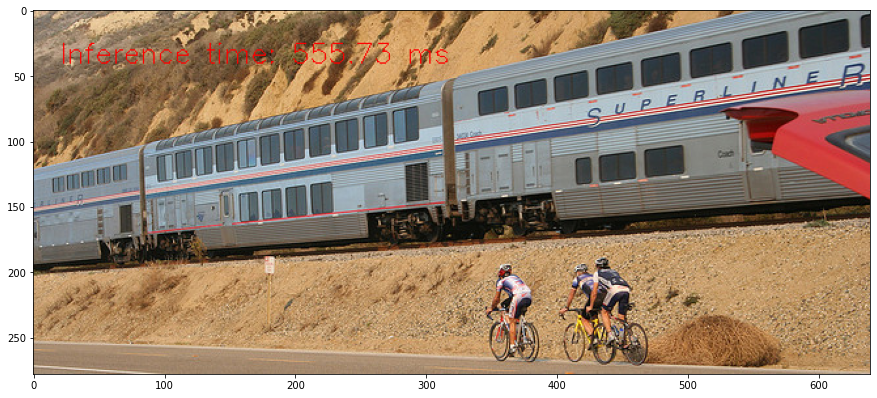

In [45]:
img_js_rand =  trainImages[np.random.randint(0, len(trainImages))]
yolo_detector.detect_objects(img_js_rand, show_detect_image=True)
yolo_detector_with_gpu.detect_objects(img_js_rand, show_detect_image=True)

In [46]:
yolo_sets              = YoloConfig(YOLOV4_CFG, YOLOV4_WEIGHTS, subClass=['person'])
yolo_sets_with_gpu     = YoloConfig(YOLOV4_CFG, YOLOV4_WEIGHTS, subClass=['person'], active_gpu=True)

yolo_detector          = objectDetectorYolo(yolo_config=yolo_sets)
yolo_detector_with_gpu = objectDetectorYolo(yolo_config=yolo_sets_with_gpu)

set gpu


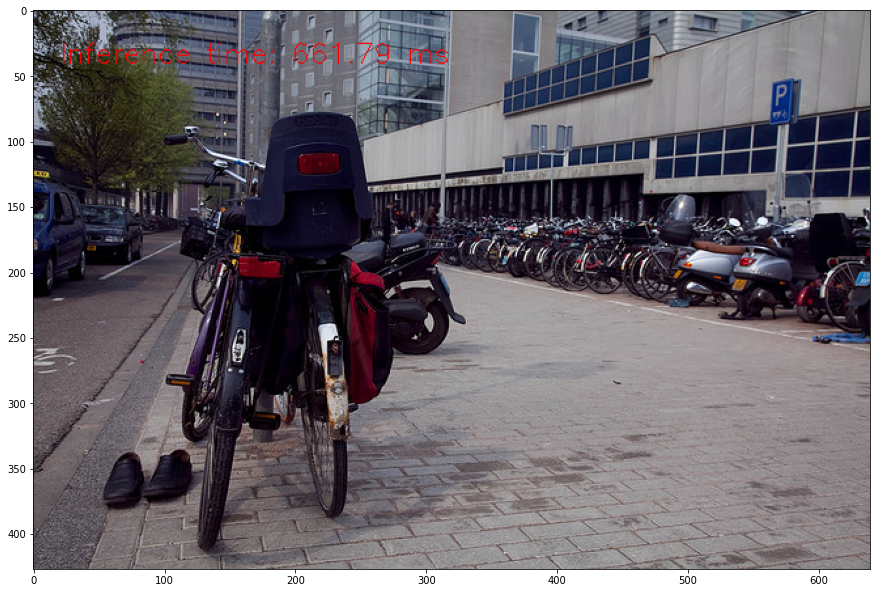

In [50]:
img_js = img_json.copy()
yolo_detector.detect_objects(img_js, show_detect_image=True)
yolo_detector_with_gpu.detect_objects(img_js, show_detect_image=False)

# YOLOv5

Choosing yolo version:


- Although the numbers vary depending on the CPU architecture, we can find a similar trend for the speed. The smaller the model, the faster it is on the CPU. From our experiments, we find that YOLOv5 Nano and Nano P6 models are the fastest. They can run at more than 30 FPS, even on an older generation i7 CPU.

-  But it is pretty safe to say that the largest models from each family (v5x, v6l, v7x, and v7d6/e6e) perform quite well. If your application demands using any of the COCO classes, then using one of the mentioned pre-trained models will give you very accurate predictions.

- If you are looking at more than 200 FPS inference speed, then RTX 4090 GPU paired with YOLO Nano/Tiny/Small models is the way to go.

- the YOLOv5 Nano model is running at 230 FPS in GPU on 640 resolution images. 

# Firstly I will encouter with yolov5 nano to see the inference time

This experiences involes in the fastest model to intergrate into digiKam

- Input Image size has to be: 640.


In [30]:
yolo_sets          = YoloConfig("", "", onnx_path=YOLOV5_NANO_ONNX, subClass=['person'])
yolo_sets_with_gpu = YoloConfig("", "", onnx_path=YOLOV5_NANO_ONNX, subClass=['person'], active_gpu=True)

yolo_detector = objectDetectorYolo(yolo_config=yolo_sets)
yolo_detector_with_gpu = objectDetectorYolo(yolo_config=yolo_sets_with_gpu)

set gpu


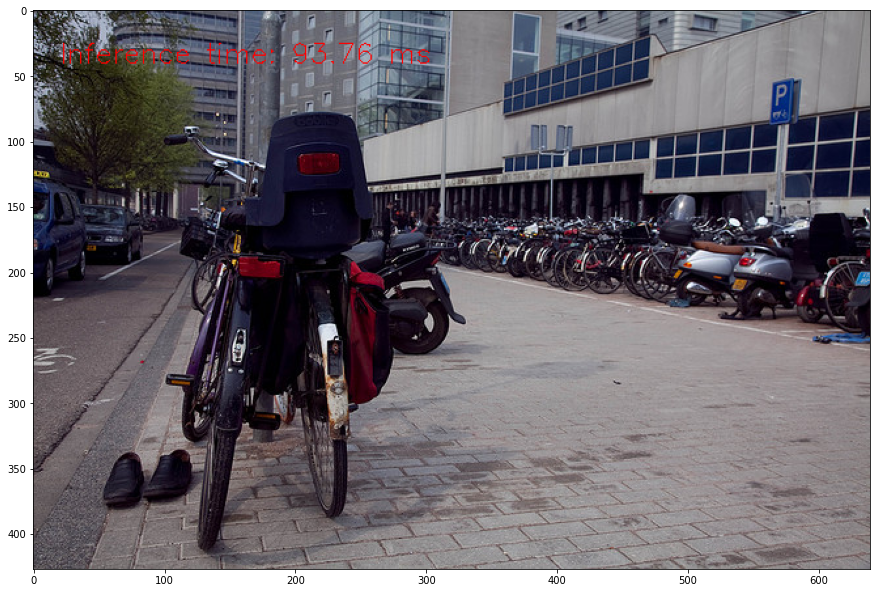

In [37]:
img_json = trainImages[np.random.randint(0, len(trainImages))]
img_js = img_json.copy()
yolo_detector.detect_objects(img_js, show_detect_image=True)
yolo_detector_with_gpu.detect_objects(img_js, show_detect_image=False)

# Firstly I will encouter with largest yolov5 to see the inference time

This experiences involes in the most accuracy model to intergrate into digiKam

- Input Image size has to be: 640.


set gpu
1


[ WARN:0@508.042] global net_impl.cpp:174 setUpNet DNN module was not built with CUDA backend; switching to CPU


1


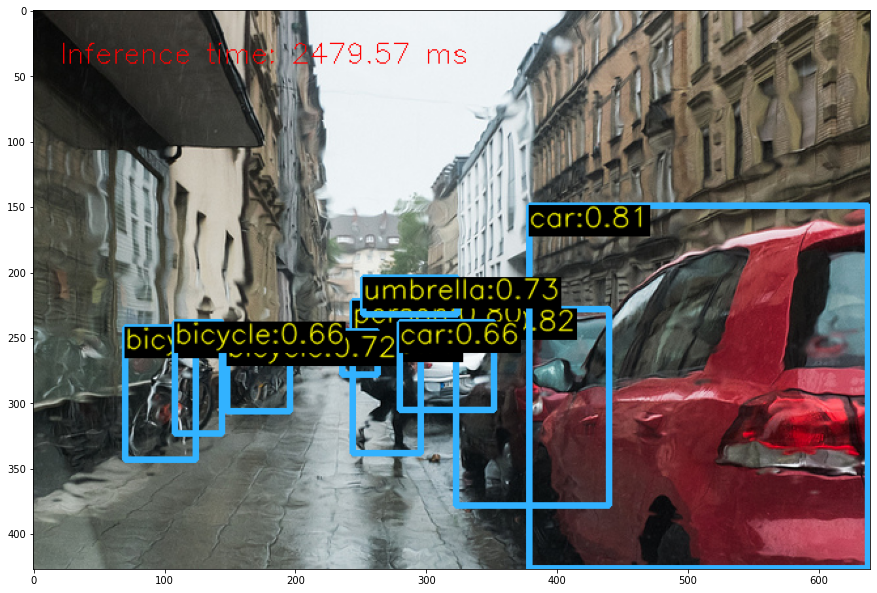

In [ ]:
yolo_sets          = YoloConfig("", "", onnx_path=YOLOV5_SIZEX_ONNX, subClass=['person'])
yolo_sets_with_gpu = YoloConfig("", "", onnx_path=YOLOV5_SIZEX_ONNX, subClass=['person'], active_gpu=True)

yolo_detector = objectDetectorYolo(yolo_config=yolo_sets)
yolo_detector_with_gpu = objectDetectorYolo(yolo_config=yolo_sets_with_gpu)

img_js = img_json.copy()
yolo_detector.detect_objects(img_js, show_detect_image=True)
yolo_detector_with_gpu.detect_objects(img_js, show_detect_image=False)